# Build your own neos!

In [2]:
from __future__ import annotations

import jax
import jax.numpy as jnp
from jax.random import PRNGKey, multivariate_normal
import pyhf
from typing import Callable, Any, Generator, Iterable
from functools import partial
import matplotlib.pyplot as plt
import neos
import os
import awkward as ak
import numpy as np



# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"  # add this
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")


# # matplotlib settings
# plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
Array = jnp.ndarray
jax.devices()

[CpuDevice(id=0)]

## Preamble
`neos` tackles the problem of learning optimal summary statistics from data. The workflow is explained in more detail [in our paper]() -- this notebook is designed to get you up-and-running with how that workflow looks in code, including how to do this for your own use-case! (if you want to do that for real, please reach out -- we'd love to help you!)

To construct this kind of workflow, you need to specify three things:
- How to construct your summary statistic from data
- How to build your likelihood function from that summary statistic
- A choice of metric relating to how you deem your analysis to be "optimal"

The second bullet in-particular is very important; while we've abstracted away all the technical detail, `neos` is still not a drop-in loss function in the typical sense, since it requires *detailed information from the analyser on how to build the likelihood*. No longer do we have a problem-agnostic notion of "signal" and "background"; instead, we're wanting to optimise our specific problem, so we need to provide specific information. That is how `neos` is "systematic-aware" -- it's a technique that explicitly takes into account how your systematics are modelled. But to do this, we of course need to model them in the first place!

Here, we're going to re-implement the example from the paper with 2-dimensional Gaussian blobs making up our data. We have a nominal estimate for signal and background data, and we also provide "up" and "down" variations that correspond to moving the mean of the background blob. The helper function to generate this dataset is below:

### Dataset generation helper function + visualisation

In [3]:
def generate_data(
    rng: int = 0,
    num_points: int = 10000,
    sig_mean: tuple[float, float] = (-1, 1),
    bup_mean: tuple[float, float] = (2.5, 2),
    bdown_mean: tuple[float, float] = (-2.5, -1.5),
    b_mean: tuple[float, float] = (1, -1),
) -> tuple[Array, Array, Array, Array]:
    sig = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(sig_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_up = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bup_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_down = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bdown_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )

    bkg_nom = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(b_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    return sig, bkg_nom, bkg_up, bkg_down


data = generate_data()

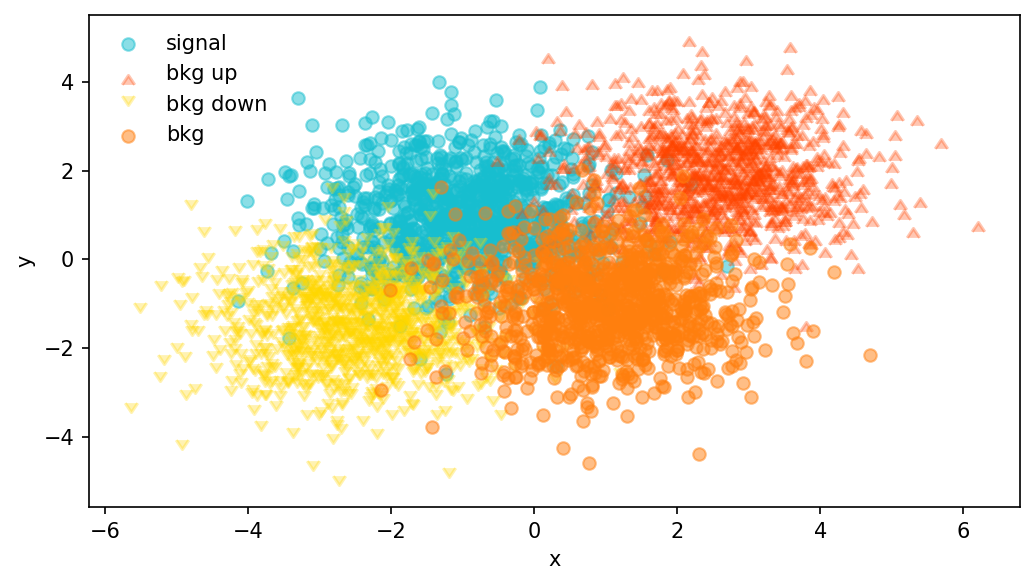

In [4]:
def plot_data_space(
    ax: Any,
    data: Array,
    params: dict[str, Any] | None = None,
    nn: Callable | None = None,
    bins: Array | None = None,
    upto=None
) -> None:
    if nn is not None:
        network = params["nn_pars"]
        bins = params["bins"] if "bins" in params else bins
        g = jnp.mgrid[-10:10:101j, -10:10:101j]
        levels = [0, *bins, 1]
        ax.contourf(
            g[0],
            g[1],
            nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
            levels=levels,
            cmap="binary",
        )
        ax.contour(
            g[0],
            g[1],
            nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
            colors="w",
            levels=levels,
        )
    sig, bkg_nom, bkg_up, bkg_down = data
    if upto is not None:
        sig, bkg_nom, bkg_up, bkg_down = sig[:upto], bkg_nom[:upto], bkg_up[:upto], bkg_down[:upto]
    # should definitely not have to repeat this every time lmao
    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.5, c="C9", label="signal")
    ax.scatter(
        bkg_up[:, 0],
        bkg_up[:, 1],
        alpha=0.3,
        c="orangered",
        marker=6,
        label="bkg up",
    )
    ax.scatter(
        bkg_down[:, 0],
        bkg_down[:, 1],
        alpha=0.3,
        c="gold",
        marker=7,
        label="bkg down",
    )
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.5, c="C1", label="bkg")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(frameon=False)


fig, ax = plt.subplots(**dict(figsize=[7, 4], dpi=150, tight_layout=True))
plot_data_space(ax, data, upto=1000)
plt.savefig("data_space.pdf", bbox_inches="tight")

Now that we have our data, we need to specify how we construct our summary statistic. We will use a neural network for this, left unspecified until later. Since our likelihood modelling stage will later involve using histograms, we'll also construct a histogram of the output, then scale the yields in each batch for a more "realistic" analysis. This step is wrapped up in a simple convenience function called `neos.hists_from_nn`, which we'll use in a moment.

After this comes the problem-specific part: the likelihood model construction. I mentioned before that we have "up" and "down" datasets -- this is a typical construct in HEP that we use to model the effect of physical parameters. We will then have three histograms for the background data: one for each of the nominal, up, and down samples. The HistFactory prescription for building likelihood functions then models the uncertainty between these by interpolating between their yields. Luckily, this is done under the hood for us in `pyhf` -- we just need to write a dictionary specifying the format of our histograms. This can be found below for our case, where we describe our uncertainty by forming a nuisance parameter `"correlated_bkg_uncertainty"` that modifies the shape of the histogram in a bin-correlated fashion. 

### Physicist's input: how to build your statistical model from histograms 

In [5]:
# assume we give a dict of histograms with keys "sig", "bkg_nominal", "bkg_up", "bkg_down".
def model_from_hists(hists: dict[str, Array]) -> pyhf.Model:
    """How to make your HistFactory model from your histograms."""
    spec = {
        "channels": [
            {
                "name": "singlechannel",  # we only have one "channel" (data region)
                "samples": [
                    {
                        "name": "signal",
                        "data": hists["sig"],  # signal
                        "modifiers": [
                            {
                                "name": "mu",
                                "type": "normfactor",
                                "data": None,
                            },  # our signal strength modifier (parameter of interest)
                        ],
                    },
                    {
                        "name": "background",
                        "data": hists["bkg_nominal"],  # background
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {
                                    "hi_data": hists["bkg_up"],  # up sample
                                    "lo_data": hists["bkg_down"],  # down sample
                                },
                            },
                        ],
                    },
                ],
            },
        ],
    }
    return pyhf.Model(spec, validate=False)

Now we just have to form our metric of choice from our likelihood model. Here, we have a variety to choose from: uncertainty on the signal strength modifier (cross-section), discovery significance, CLs, even the classic binary cross-entropy (that doesn't use the likelihood at all). Instead of overloading the notebook with losses, I've baked them all into `neos.loss_from_model`, which takes in a `pyhf` model and a string with the metric you want to calculate.

With these ingredients, we just need to compose them in one function, so we can take the gradient of that function with respect to our free parameters:

### Build pipeline by combining functions from the `neos` module with our model builder

In [6]:
def pipeline(
    pars: dict[str, Array],
    data: tuple[Array, ...],
    nn: Callable,
    loss: str,
    bandwidth: float,
    sample_names: Iterable[str],  # we're using a list of dict keys for bookkeeping!
    scale_factors: dict[str, float],
    bins: Array | None = None,  # in case you don't want to optimise binning
    lumi: float = 10.0,  # overall scale factor
) -> float:
    # zip up our data arrays with the corresponding sample names
    data_dct = {k: v for k, v in zip(sample_names, data)}

    # if you want s/b discrimination, no need to do anything complex!
    if loss.lower() in ["bce", "binary cross-entropy"]:
        return neos.losses.bce(data=data_dct, pars=pars["nn_pars"], nn=nn, background_label="bkg_nominal")

    # use a neural network + differentiable histograms [bKDEs] to get the yields
    hists = neos.hists_from_nn(
        pars=pars["nn_pars"],
        nn=nn,
        data=data_dct,
        bandwidth=bandwidth,  # for the bKDEs
        bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
        scale_factors=scale_factors,
        overall_scale=lumi,
    )
    hists = {k:v+1e-2 for k,v in hists.items()}  # no empty bins
#     hists = {k:v + jax.random.uniform(PRNGKey(0)) if (k == "bkg_up") or (k == "bkg_down") else v for k,v in hists.items()}
    # build our statistical model, and calculate the loss!
    model = model_from_hists(hists)
    return neos.loss_from_model(model, loss=loss)

def pipeline_comb(
    pars: dict[str, Array],
    data: tuple[Array, ...],
    nn: Callable,
    bandwidth: float,
    sample_names: Iterable[str],  # we're using a list of dict keys for bookkeeping!
    scale_factors: dict[str, float],
    bins: Array | None = None,  # in case you don't want to optimise binning
    lumi: float = 10.0,  # overall scale factor
) -> float:
    # zip up our data arrays with the corresponding sample names
    data_dct = {k: v for k, v in zip(sample_names, data)}

    # use a neural network + differentiable histograms [bKDEs] to get the yields
    hists = neos.hists_from_nn(
        pars=pars["nn_pars"],
        nn=nn,
        data=data_dct,
        bandwidth=bandwidth,  # for the bKDEs
        bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
        scale_factors=scale_factors,
        overall_scale=lumi,
    )
    hists = {k:v+1e-2 for k,v in hists.items()}  # no empty bins
#     hists = {k:v + jax.random.uniform(PRNGKey(0)) if (k == "bkg_up") or (k == "bkg_down") else v for k,v in hists.items()}
    # build our statistical model, and calculate the loss!
    model = model_from_hists(hists)
    return neos.loss_from_model(model, loss="discovery") + neos.loss_from_model(model, loss="CLs")

Below is now mostly training boilerplate! I'll add titles, but should be mostly clear what's going on (ask if not!)

### Initialise network architecture + params

In [7]:
from jax.example_libraries import stax


# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(128),
    stax.Relu,
    stax.Dense(128),
    stax.Relu,
    stax.Dense(128),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

num_features = 2


### Define batching mechanism for data

In [8]:
from sklearn.model_selection import train_test_split
import numpy.random as npr

batch_size = 4000  # change me if you want!
split = train_test_split(*data, random_state=0)
train, test = split[::2], split[1::2]


def batches(training_data: Array, batch_size: int) -> Generator:
    num_train = training_data[0].shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism, ripped from the JAX docs :)
    def data_stream():
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield [points[batch_idx] for points in train]

    return data_stream()


batch_iterator = batches(train, batch_size)

In [9]:
# Patrick Kidger's hacky way to clean up JAX cache!
# Needed because we do jax.closure_convert under the hood.
# This lowers the computational representation to jaxprs, which are slow
# unless jitted! But they also stay in cache. So we have lots of cache.

import gc
import random
import sys

import jax
import jax.config
import jax.random as jrandom
import psutil

def clear_caches():
    process = psutil.Process()
    if process.memory_info().vms > 2 * 2**30:  # >4GB memory usage
        jax.clear_backends()
        for module_name, module in sys.modules.items():
            if module_name.startswith("jax"):
                if module_name not in ["jax.interpreters.partial_eval"]:
                    for obj_name in dir(module):
                        obj = getattr(module, obj_name)
                        if hasattr(obj, "cache_clear"):
                            try:
                                obj.cache_clear()
                            except Exception:
                                pass
        gc.collect()

### Training loop definition


In [10]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter
from copy import deepcopy


def run_optimisation(
    init_pars: Array,
    num_steps: int,
    objective: str,
    test_objective: str,
    lr: float,
    bins: Array,
    data_types: Iterable[str],
    scale_factors: dict[str, float],
    include_bins: bool = True,
    bandwidth = 9e-2,
) -> tuple[Array, dict[str, list]]:

    loss = partial(
        pipeline,
        nn=nn,
        sample_names=data_types,
        scale_factors=scales,
    )

    solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

    pyhf.set_backend("jax", default=True)

    if include_bins:
        init_pars["bins"] = bins[
            1:-1
        ]  # don't want to float endpoints [will account for kde spill]
        state = solver.init_state(init_pars)
    else:
        if "bins" in init_pars:
            del init_pars["bins"]
        state = solver.init_state(init_pars)

    params = init_pars
    best_params = init_pars
    best_sig = 999
    metrics = {k: jnp.array([]) for k in ["CLs", "discovery", "poi_uncert", "bce"]}

    for i in range(num_steps):
        if i % 10 == 0:
            prt = True
            print('clearing caches...')
            clear_caches()
            print('...cleared!')
        else:
            prt = False
        print(f"step {i}: loss={objective}")
        data = next(batch_iterator)
        start = perf_counter()
        params, state = solver.update(
            params, state, bins=bins, data=data, loss=objective, bandwidth=bandwidth
        )
        end = perf_counter()
        if prt:
            print(f"update took {end-start:.4g}s")
        if "bins" in params:
            if prt:
                print("bin edges: [0 ", *[f"{f:.3g}" for f in params["bins"]], " 1]")
        for metric in metrics:
            if metric != "loss":
                test_metric = loss(
                    params, bins=bins, data=test, loss=metric, bandwidth=1e-8
                )
                if prt:
                    print(f"{metric}={test_metric:.4g}")
                if i == 0:
                    metrics[metric] = jnp.array([test_metric])
                else:
                    metrics[metric] = jnp.concatenate((metrics[metric],jnp.array([test_metric])))
        if best_sig != 0:
            if metrics[test_objective][-1] < best_sig:
                best_params = params
                best_sig = deepcopy(metrics[test_objective][-1])
            

        if prt:
            print()
    metrics = {k:np.array(v) for k,v in metrics.items()}
    print(best_sig)
    return best_params, metrics

from jaxopt import OptaxSolver
import optax
from time import perf_counter
from copy import deepcopy


def run_optimisation_comb(
    init_pars: Array,
    num_steps: int,
    lr: float,
    bins: Array,
    data_types: Iterable[str],
    scale_factors: dict[str, float],
    include_bins: bool = True,
    bandwidth = 9e-2,
) -> tuple[Array, dict[str, list]]:

    loss = partial(
        pipeline_comb,
        nn=nn,
        sample_names=data_types,
        scale_factors=scales,
    )
    
    loss_met = partial(
        pipeline,
        nn=nn,
        sample_names=data_types,
        scale_factors=scales,
    )

    solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

    pyhf.set_backend("jax", default=True)

    if include_bins:
        init_pars["bins"] = bins[
            1:-1
        ]  # don't want to float endpoints [will account for kde spill]
        state = solver.init_state(init_pars)
    else:
        if "bins" in init_pars:
            del init_pars["bins"]
        state = solver.init_state(init_pars)

    params = init_pars
    best_params = init_pars
    best_sig = 999
    metrics = {k: jnp.array([]) for k in ["CLs", "discovery", "poi_uncert", "bce", "loss"]}

    for i in range(num_steps):
        if i % 20 == 0:
            prt = True
        elif i % 10 == 0:
            clear_caches()
        else:
            prt = False
        if prt:
            print(f"step {i}: loss=p0+CLs")
        data = next(batch_iterator)
        start = perf_counter()
        params, state = solver.update(
            params, state, bins=bins, data=data, bandwidth=bandwidth
        )
        end = perf_counter()
        if prt:
            print(f"update took {end-start:.4g}s")
        if "bins" in params:
            if prt:
                print("bin edges: [0 ", *[f"{f:.3g}" for f in params["bins"]], " 1]")
        for metric in metrics:
            if metric != "loss":
                test_metric = loss_met(
                    params, bins=bins, data=test, loss=metric, bandwidth=1e-8
                )
                if prt:
                    print(f"{metric}={test_metric:.4g}")
                if i == 0:
                    metrics[metric] = jnp.array([test_metric])
                else:
                    metrics[metric] = jnp.concatenate((metrics[metric],jnp.array([test_metric])))
            else:
                test_metric = loss(
                    params, bins=bins, data=test, bandwidth=1e-8
                )
                if prt:
                    print(f"{metric}={test_metric:.4g}")
                if i == 0:
                    metrics[metric] = jnp.array([test_metric])
                else:
                    metrics[metric] = jnp.concatenate((metrics[metric],jnp.array([test_metric])))
                
        if best_sig != 0:
            if metrics["loss"][-1] < best_sig:
                best_params = params
                best_sig = deepcopy(metrics["loss"][-1])
            

        if prt:
            print()
    metrics = {k:np.array(v) for k,v in metrics.items()}
    print(best_sig)
    return best_params, metrics

### Run!

In [13]:
lr = 1e-3
num_steps = 200


# the same keys you used in the model building step [model_from_hists]
data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
scales = {k: 2.0 if k == "sig" else 10.0 for k in data_types}

# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
def run_neos(setting, init, bins, bandwidth):
    objective = test_metric = setting
    return run_optimisation(
        init, num_steps, objective, test_metric, lr, bins, data_types, scales, include_bins, bandwidth
    )

# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
def run_neos_comb(binning, init, bandwidth):
    return run_optimisation_comb(
        init, num_steps, lr, binning, data_types, scales, include_bins, bandwidth
    )

settings = ["bce", "poi_uncert", "CLs", "discovery"]

In [ ]:
## this is the real training -- i've saved the result though, this is super slow

# for include_bins in [False]:
#     # can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
#     def run_neos(setting, init, bins, bandwidth):
#         objective = test_metric = setting
#         return run_optimisation(
#             init, num_steps, objective, test_metric, lr, bins, data_types, scales, include_bins, bandwidth
#         )

#     # can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
#     def run_neos_comb(binning, init, bandwidth):
#         return run_optimisation_comb(
#             init, num_steps, lr, binning, data_types, scales, include_bins, bandwidth
#         )

#     for setting in ["COMB", "poi_uncert", "CLs", "discovery"]:
#         for num_bins in [20]:
#             bins = jnp.linspace(0, 1, num_bins + 1)
#             for state in range(9):
#                 _, init = init_random_params(PRNGKey(state), (-1, num_features))
#                 init_pars = dict(nn_pars=init)
#                 if setting == "COMB":
#                     pars, metrics = run_neos_comb(bins, init_pars, 0.09/4)
#                 else:
#                     pars, metrics = run_neos(setting, init_pars, bins, 0.09/4)
#                 yields = neos.hists_from_nn(
#                     pars["nn_pars"],
#                     {k: v for k, v in zip(data_types, test)},
#                     nn,
#                     bandwidth=1e-8,
#                     scale_factors=scales,
#                     bins=bins,
#                 )
#                 g = jnp.mgrid[-7:7:101j, -7:7:101j]
#                 grid = np.array(nn(pars["nn_pars"], jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0])
#                 if include_bins:
#                     big_dict = dict(bins=np.array([0,*pars["bins"], 1]), **metrics, **{k:np.array(v) for k,v in yields.items()}, grid=grid)
#                     ak.to_parquet([ak.Record(big_dict)], f"BINS-GRID{setting}{state}bins{num_bins}steps200.parquet")
#                 else:
#                     big_dict = dict(bins=np.array(bins), **metrics, **{k:np.array(v) for k,v in yields.items()}, grid=grid)
#                     ak.to_parquet([ak.Record(big_dict)], f"NOBINS-GRID{setting}{state}bins{num_bins}steps200.parquet")

            


### Metrics

In [1]:
## Run me if you did the training!

# fields = settings+["sig", "bkg_nominal", "bkg_up", "bkg_down", "bins","grid"]
# new_settings = settings+["COMB"]
# dct = {s:{f:[] for f in fields} for s in new_settings}

# for num_bins in [20]:
#     dct = {s:{f:[] for f in fields} for s in new_settings}

#     for s in new_settings:
#         print(s)
#         for state in range(9):
#             for s2 in fields:
#                 dct[s][s2].append(ak.from_parquet(f"NOBINS-GRID{s}{state}bins{num_bins}steps200.parquet")[s2])
            

#     ak.to_parquet(ak.Array(dct), f'resultsgrid{num_bins}nobins2.parquet')

NameError: name 'settings' is not defined

In [14]:
# pick your fave!
arr = ak.from_parquet("resultsgrid20bins.parquet")
arr = ak.from_parquet("resultsgrid5bins.parquet")

Text(0.5, 0.98, 'Test set metrics for optimizing a neural network observable (# bins = 20)')

<Figure size 432x288 with 0 Axes>

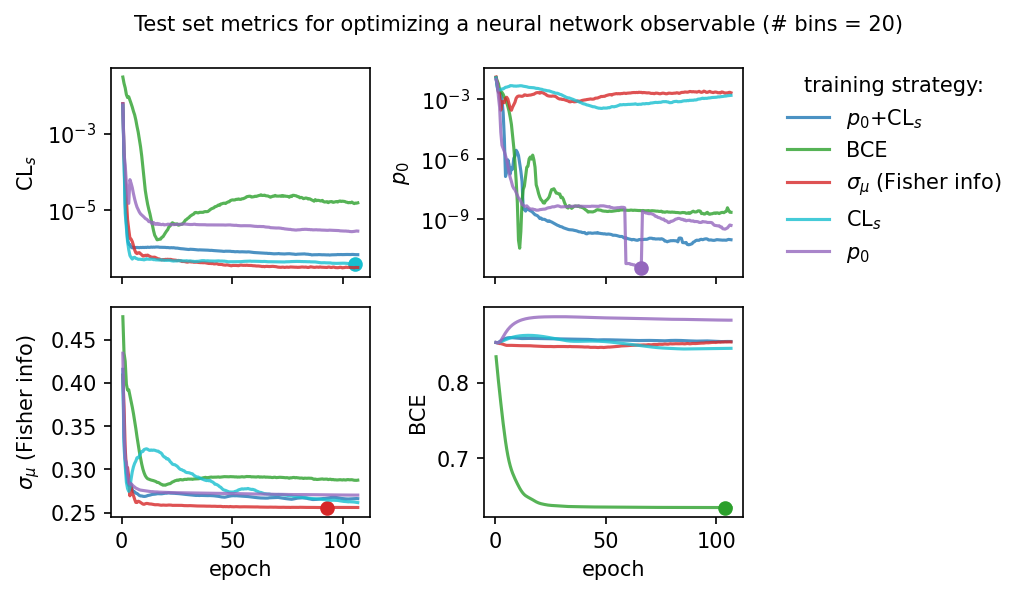

In [15]:
settings = ["bce", "poi_uncert", "CLs", "discovery"]
num_steps=200
epoch_grid = (jnp.array(list(range(1, num_steps + 1))) * batch_size) / train[0].shape[0]
fig = plt.figure(constrained_layout=True)
fig, axs = plt.subplots(2,2, **dict(figsize=[7, 4], dpi=150, tight_layout=True, sharex=True))
colors = {"bce":"C2", "poi_uncert":"C3", "CLs":"C9", "discovery":"C4", "COMB":"C0"}
axs = axs.ravel()

def mean(arr, index, quantity):
    return np.nanmean(arr[index][quantity] ,axis=0, where=arr[index][quantity]>0)[0]

labels = {"bce":"BCE", "poi_uncert":"$\sigma_{\mu}$ (Fisher info)", "CLs":"CL$_s$", "discovery":"$p_0$", "COMB":"$p_0$+CL$_s$"}
for i, k in enumerate(['COMB']+settings):
    ax = axs[0]
    
    ax.plot(epoch_grid, mean(arr, k, "CLs"), label = labels[k], c = colors[k], alpha=0.8)
    if k == "CLs":
        idx = np.argmin(mean(arr, k, "CLs"))
        ax.scatter(epoch_grid[idx], mean(arr, k, "CLs")[idx],c = colors[k])
    ax.set_ylabel(labels["CLs"])
    ax = axs[1]
    ax.plot(epoch_grid, mean(arr, k, "discovery"), label = labels[k],c = colors[k], alpha=0.8)
    if k == "discovery":
        idx = np.argmin(mean(arr, k, "discovery"))
        ax.scatter(epoch_grid[idx], mean(arr, k, "discovery")[idx], c = colors[k])
    ax.set_ylabel(labels["discovery"])
    ax = axs[2]
    ax.plot(epoch_grid, mean(arr, k, "poi_uncert"), label = labels[k],c = colors[k], alpha=0.8)
    if k == "poi_uncert":
        idx = np.argmin(mean(arr, k, "poi_uncert"))
        ax.scatter(epoch_grid[idx], mean(arr, k, "poi_uncert")[idx], c = colors[k])
    ax.set_ylabel(labels["poi_uncert"])
    ax = axs[3]
    ax.plot(epoch_grid, mean(arr, k, "bce"), label = labels[k],c = colors[k], alpha=0.8)
    if k == "bce":
        idx = np.argmin(mean(arr, k, "bce"))
        ax.scatter(epoch_grid[idx], mean(arr, k, "bce")[idx], c = colors[k])
    ax.set_ylabel("BCE")

for ax in axs[:2]:
    ax.set_yscale("log")
for ax in axs[2:]:
    ax.set_xlabel("epoch")
    
axs[1].legend(bbox_to_anchor=(1.1, 1.05), frameon=False, title = "training strategy:")
plt.suptitle("Test set metrics for optimizing a neural network observable (# bins = 20)", fontsize="medium")
# plt.savefig("test_metricsmanynobins.pdf", bbox_inches="tight")

### Histograms

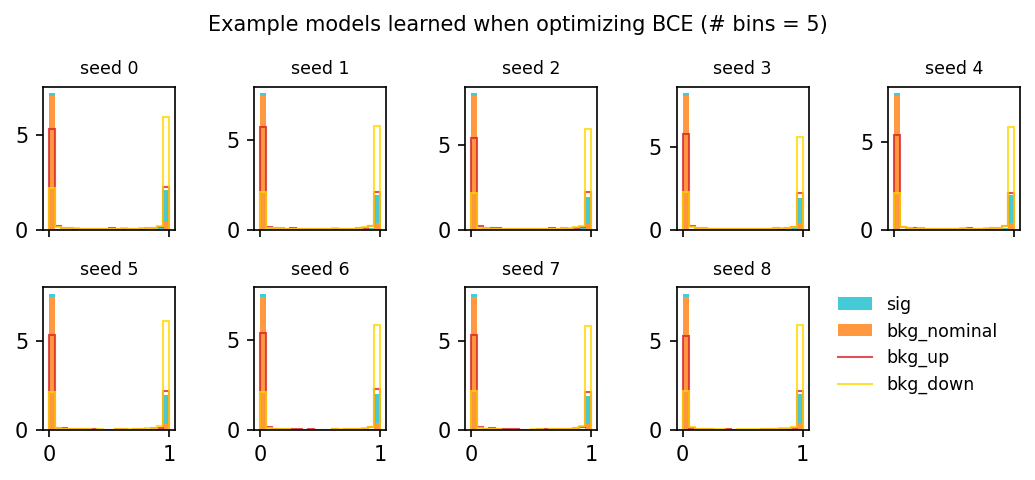

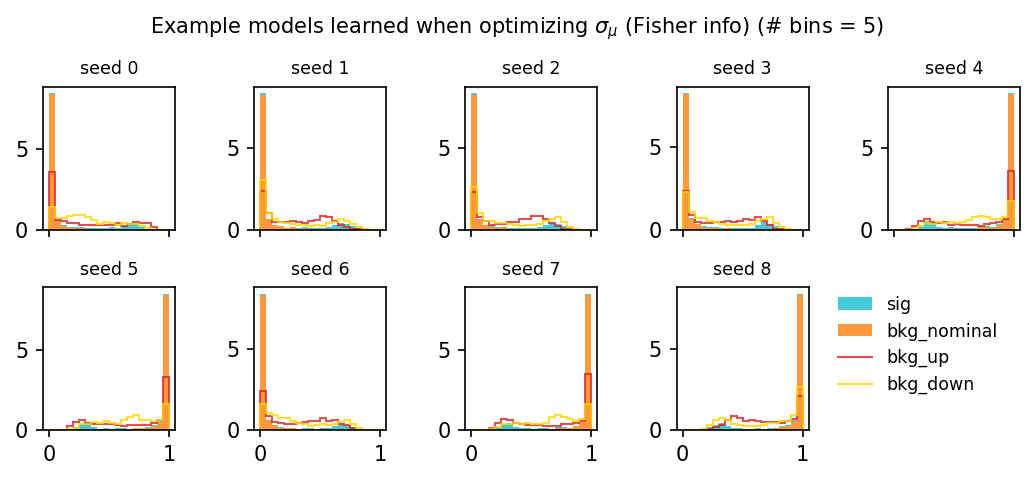

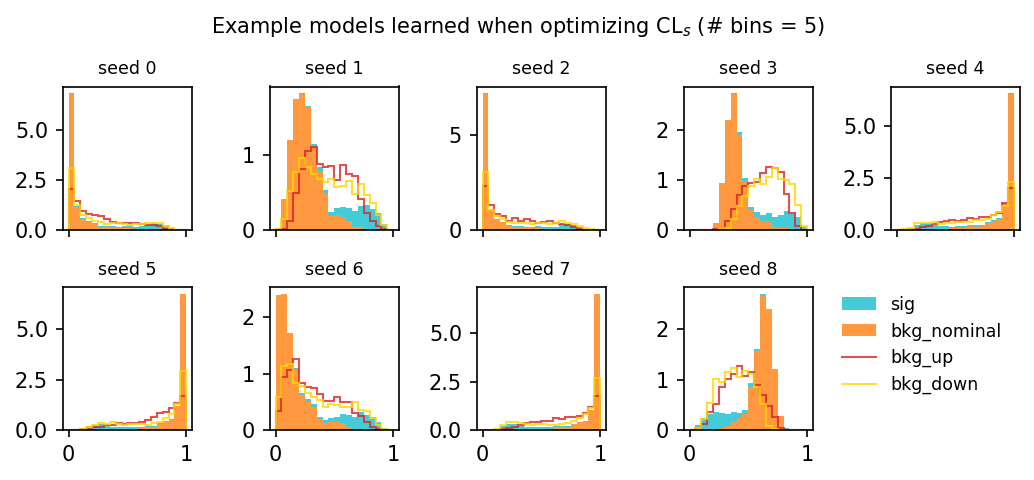

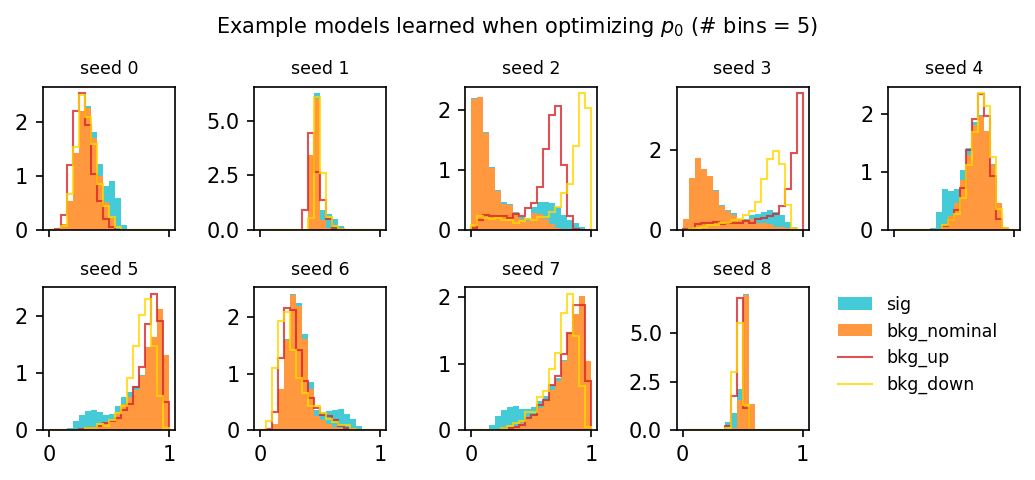

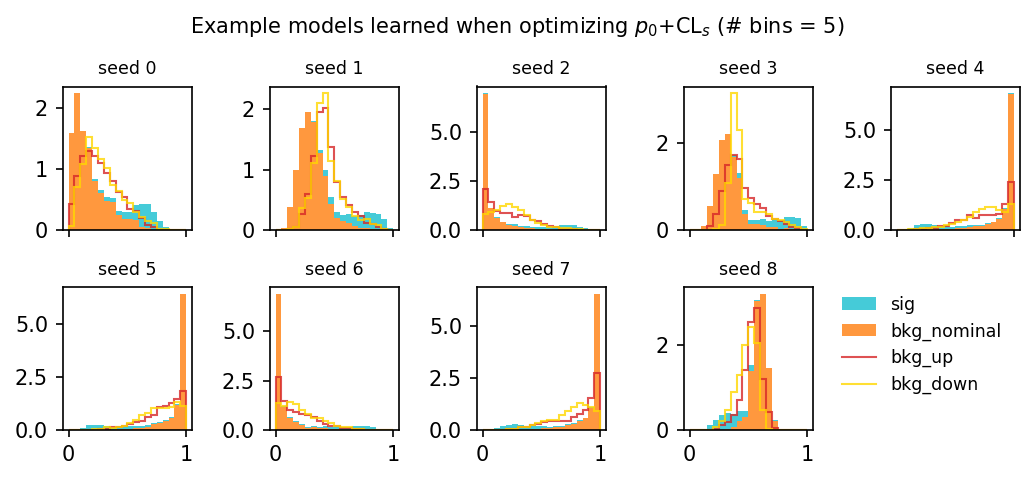

In [17]:
from plothelp import autogrid

def plot_hist(dct):
    ax, data, i = list(dct.values())
    counts = ak.Record(data)[["sig", "bkg_nominal", "bkg_up", "bkg_down", "bins"]]
    # binning = jnp.array([0, *best_params["bins"], 1])
    binning = counts["bins"][0]
    ax.stairs(counts["sig"][0]+counts["bkg_nominal"][0], binning, label="sig", alpha=0.8, color='C9', fill=True, baseline=counts["bkg_nominal"][0])
    ax.stairs(counts["bkg_nominal"][0], binning, label="bkg_nominal", alpha=0.8, color='C1', fill=True)
    ax.stairs(counts["bkg_up"][0], binning, label="bkg_up", alpha=0.8, fill=None, edgecolor='C3', linewidth=1)
    ax.stairs(counts["bkg_down"][0], binning, label="bkg_down", alpha=0.8, fill=None, edgecolor='gold', linewidth=1)
    ax.set_title(f"seed {i}", fontsize="small")
    if i==8:
        ax.legend(bbox_to_anchor=(1.1, 1.05), frameon=False, fontsize="small")

#     ax.legend(loc="upper left", frameon=False)

for field in arr.fields:
    autogrid(
        arr[f"{field}"],
        plot_hist,
        subplot_kwargs=dict(figsize=[7, 3], dpi=150, sharex=True),
        plots_per_row=5,
#         title=
    );
    plt.suptitle(f"Example models learned when optimizing {labels[field]} (# bins = 5)", fontsize="medium", y=1.05)
#     plt.tight_layout()
    plt.subplots_adjust(hspace=0.4,wspace=0.6)
    plt.savefig(f"new-hist-models-{field}-5nobin.pdf", bbox_inches="tight")

#     plt.savefig("uhist-new.png")

/home/jovyan/.local/lib/python3.8/site-packages/plothelp/plot.py:124: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/home/jovyan/.local/lib/python3.8/site-packages/plothelp/plot.py:124: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/home/jovyan/.local/lib/python3.8/site-packages/plothelp/plot.py:124: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/home/jovyan/.local/lib/python3.8/site-packages/plothelp/plot.py:124: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/home/jovyan/.local/lib/python3.8/site-packages/plothelp/plot.py:124: UserWarning: Tight layout not applied. tight_layout cannot make axes w

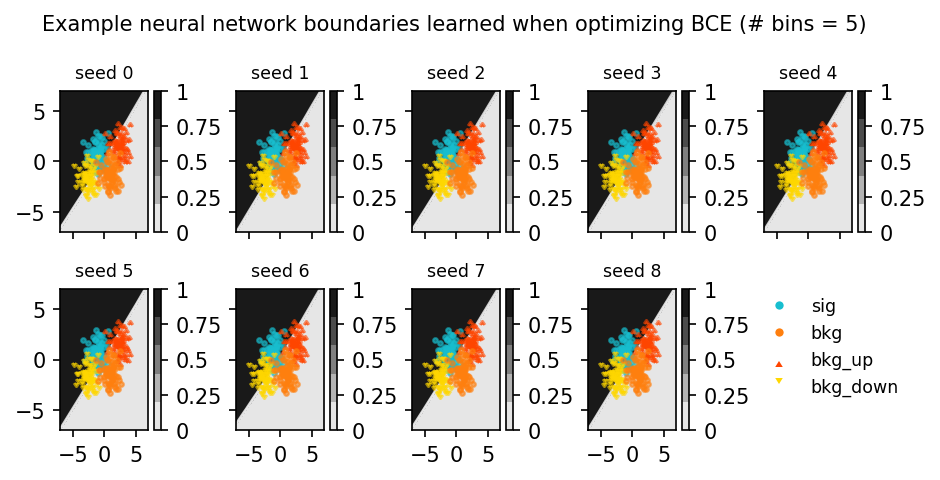

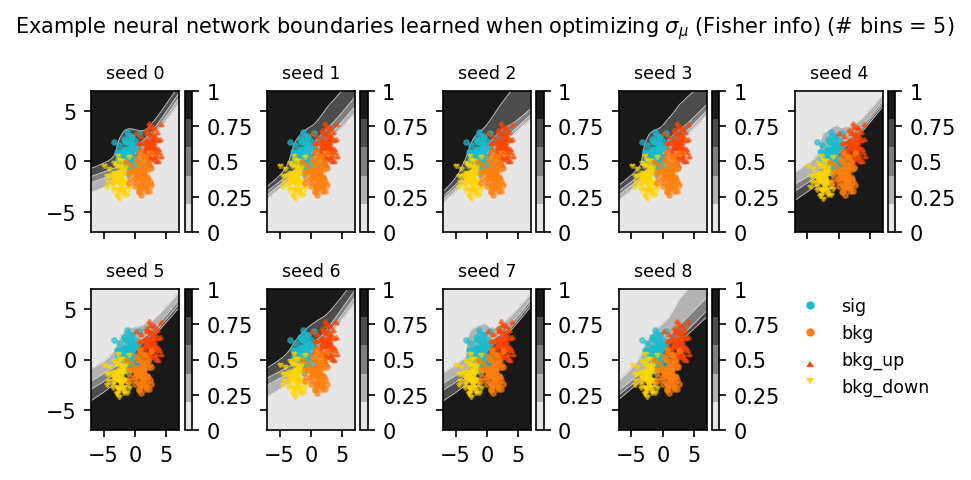

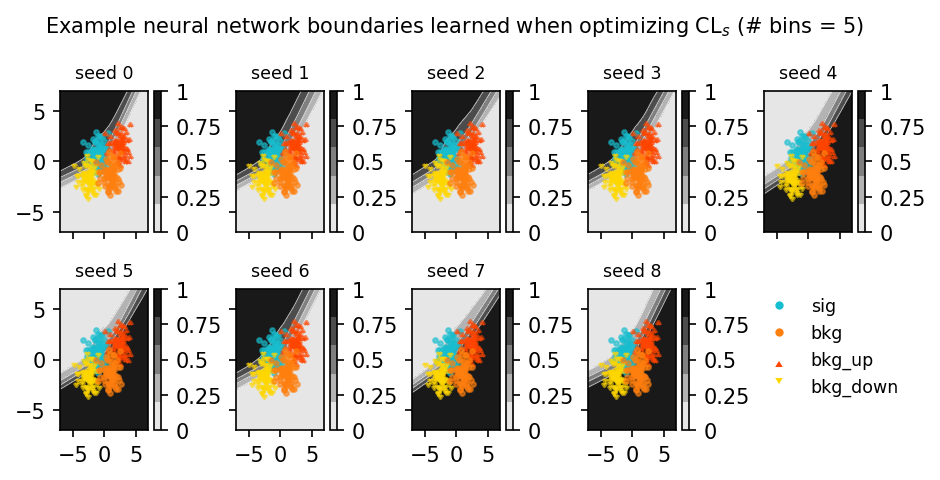

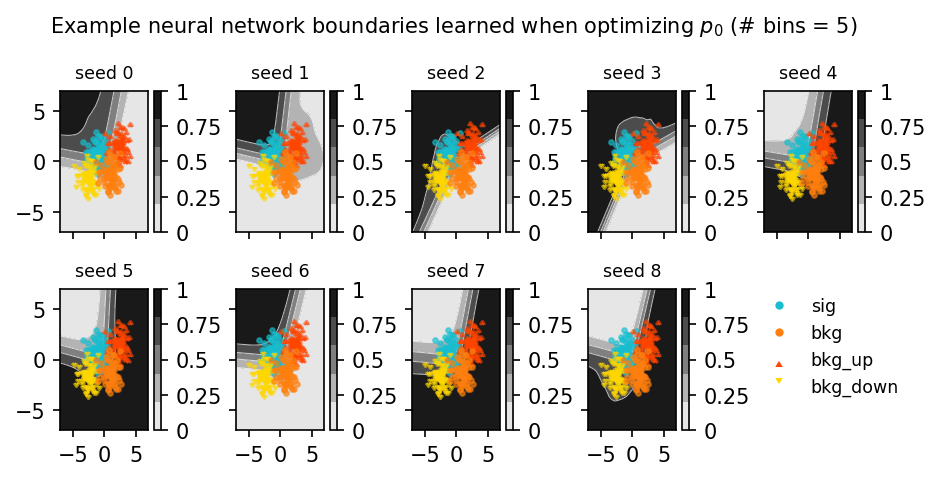

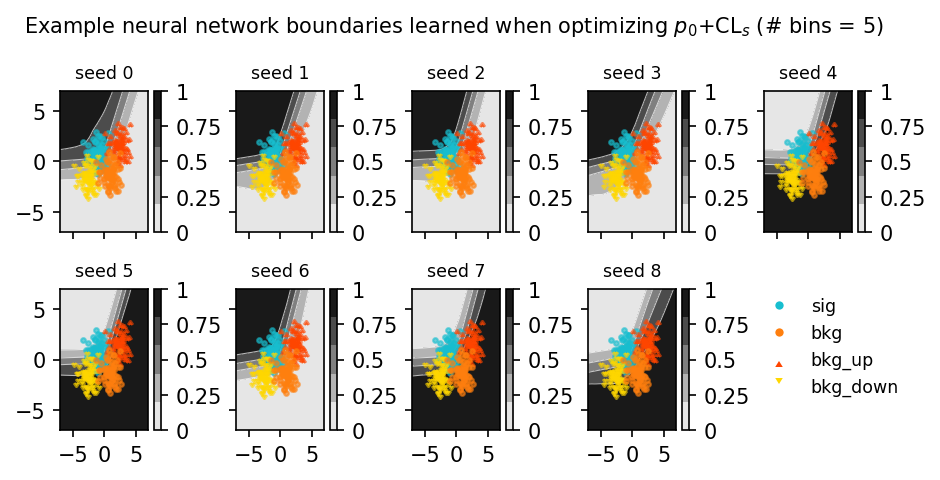

In [26]:
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from matplotlib.lines import Line2D

def plot_space(
    dct,
    num_scatter=70,
) -> None:
    ax, data, i = list(dct.values())
    
    bins = data.bins
    grid = data.grid.to_numpy()[0]
#     print(bins[0])
    g = jnp.mgrid[-7:7:101j, -7:7:101j]
    levels = np.sort(bins[0])
    a = ax.contourf(
        g[0],
        g[1],
        grid,
        levels=levels,
        cmap="binary",
        zorder=-999
    )
    ax.contour(
        g[0],
        g[1],
        grid,
        colors="w",
        levels=levels,
        linewidths=0.5,
        alpha=0.7,
        zorder=-998
    )
    cb = plt.colorbar(a, ax=ax, format=FormatStrFormatter('%.2g'))
    tick_locator = MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()
    sig, bkg_nom, bkg_up, bkg_down = test
    # should definitely not have to repeat this every time lmao
    size = 5
    ax.scatter(sig[:, 0][:num_scatter], sig[:, 1][:num_scatter], alpha=0.6, c="C9", label="signal", s=size)
    ax.scatter(
        bkg_up[:, 0][:num_scatter],
        bkg_up[:, 1][:num_scatter],
        alpha=0.6,
        c="orangered",
        marker=6,
        label="bkg up",
        s=size,
    )
    ax.scatter(
        bkg_down[:, 0][:num_scatter],
        bkg_down[:, 1][:num_scatter],
        alpha=0.6,
        c="gold",
        marker=7,
        label="bkg down",
        s=size,
    )
    ax.scatter(bkg_nom[:, 0][:num_scatter], bkg_nom[:, 1][:num_scatter], alpha=0.6, c="C1", label="bkg", s=size)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
    ax.set_title(f"seed {i}", fontsize="small")
    
    if i==8:
        legend_handles = [
            Line2D([0], [0], marker='o', color='w', label='sig', markerfacecolor='C9', markersize=5),
            Line2D([0], [0], marker='o', color='w', label='bkg', markerfacecolor='C1', markersize=5),
            Line2D([0], [0], marker=6, color='w', label='bkg_up', markerfacecolor='orangered', markersize=5),
            Line2D([0], [0], marker=7, color='w', label='bkg_down', markerfacecolor='gold', markersize=5),
        ]
        ax.legend(handles=legend_handles, bbox_to_anchor=(1.8, 1.05), frameon=False, fontsize="small")



#     ax.legend(loc="upper left", frameon=False)

for field in arr.fields:
    autogrid(
        arr[f"{field}"],
        plot_space,
        subplot_kwargs=dict(figsize=[7, 3], dpi=150, sharex=True, sharey=True),
        plots_per_row=5,
#         title=
    );
    plt.suptitle(f"Example neural network boundaries learned when optimizing {labels[field]} (# bins = 5)", fontsize="medium", y=1.05)
#     plt.tight_layout()
    plt.subplots_adjust(hspace=0.4,wspace=0.6)
    plt.savefig(f"new-grid-models-{field}-5nobin.pdf", bbox_inches="tight")

# Cover image

[0, 0.0406, 0.0909, 0.143, 0.198, 0.254, ... 0.749, 0.809, 0.864, 0.922, 0.97, 1]


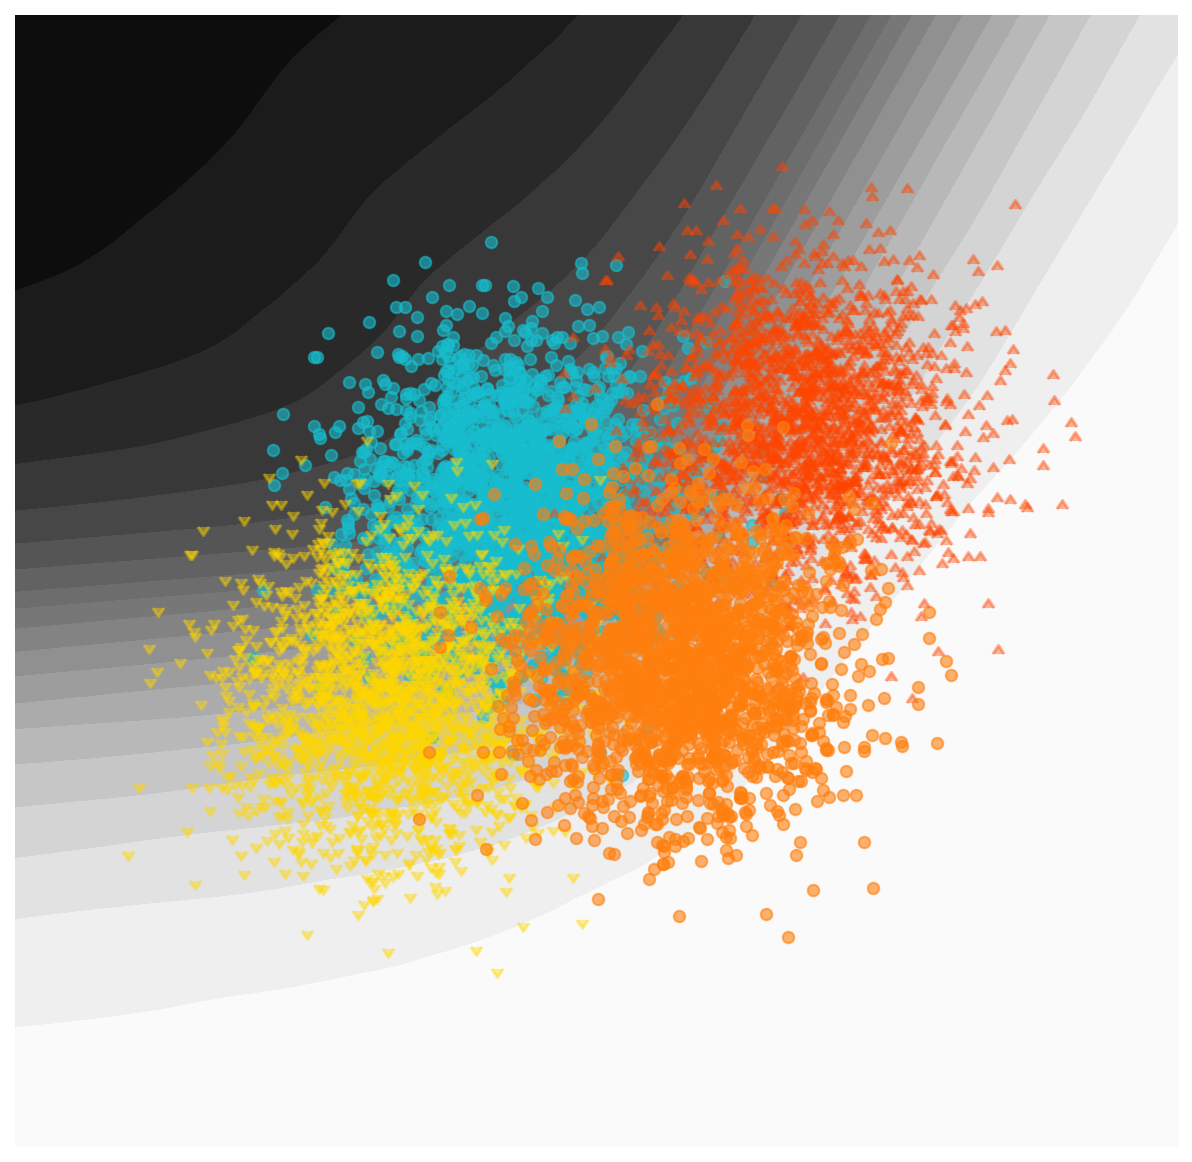

In [24]:
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from matplotlib.lines import Line2D


#     ax.legend(loc="upper left", frameon=False)
fig, ax = plt.subplots(figsize=[10,10], dpi=150)
data = arr.COMB[0]
bins = data.bins
grid = data.grid.to_numpy()[0]
print(bins[0])
g = jnp.mgrid[-7:7:101j, -7:7:101j]
levels = np.sort(bins[0])
a = ax.contourf(
    g[0],
    g[1],
    grid,
    levels=levels,
    cmap="binary",
)
# ax.contour(
#     g[0],
#     g[1],
#     grid,
#     colors="w",
#     levels=levels,
#     linewidths=0.5,
#     alpha=0.7
# )
# cb = plt.colorbar(a, ax=ax, format=FormatStrFormatter('%.2g'))
# tick_locator = MaxNLocator(nbins=4)
# cb.locator = tick_locator
# cb.update_ticks()
sig, bkg_nom, bkg_up, bkg_down = test
# should definitely not have to repeat this every time lmao
num_scatter=2000
size = 30
scatter = True
if scatter:
    ax.scatter(sig[:, 0][:num_scatter], sig[:, 1][:num_scatter], alpha=0.6, c="C9", label="signal", s=size)
    ax.scatter(
        bkg_up[:, 0][:num_scatter],
        bkg_up[:, 1][:num_scatter],
        alpha=0.4,
        c="orangered",
        marker=6,
        label="bkg up",
        s=size,
    )
    ax.scatter(
        bkg_down[:, 0][:num_scatter],
        bkg_down[:, 1][:num_scatter],
        alpha=0.4,
        c="gold",
        marker=7,
        label="bkg down",
        s=size,
    )
    ax.scatter(bkg_nom[:, 0][:num_scatter], bkg_nom[:, 1][:num_scatter], alpha=0.6, c="C1", label="bkg", s=size)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
# ax.set_title(f"seed {i}", fontsize="small")

if i==8:
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label='sig', markerfacecolor='C9', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='bkg', markerfacecolor='C1', markersize=5),
        Line2D([0], [0], marker=6, color='w', label='bkg_up', markerfacecolor='orangered', markersize=5),
        Line2D([0], [0], marker=7, color='w', label='bkg_down', markerfacecolor='gold', markersize=5),
    ]
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.8, 1.05), frameon=False, fontsize="small")
plt.axis("off")
plt.savefig("cover-bw.png", bbox_inches='tight')